# Tree Based Methods for TKN Prediction in Influent Wastewater

Model Iteration No. 1 - This code uses all project feature inputs (BOD5, CBOD5, VTS, SS, VSS, TS, P-TOT, P-SOL). This code served as the first step. See below for SHAP value evaluations. These evaluations inform Appendix G, Model Iteration No. 2, which is the final project model.

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras

# For random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree

# For gradient boosting 
from xgboost import XGBRegressor

# For evaluation 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [27]:
# For training data split
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

# Import the Data

In [28]:
influent_data = pd.read_excel(r"C:\Users\18455\EAEE4000_ML_Jupyter\EAEE4000_WW_Prediction\Appendix_A_Preprocessing_and_DataReview\raw_influent.xlsx")
influent_data

,Unnamed: 0,Date,BOD5,CBOD5,SS,VSS,TS,VTS,TKN,Nitrates,P-TOT,P-SOL
0,2672,2008-01-01,67,55,82,64,1994,188,18.53,0.72,2.65,1.155
1,2673,2008-01-02,77,57,70,61,1274,196,19.87,0.85,4.22,2.849
2,2674,2008-01-03,94,70,84,69,1096,220,21.49,0.81,5.53,3.809
3,2675,2008-01-04,93,64,72,54,1003,242,19.32,0.65,6.19,4.107
4,2676,2008-01-05,107,75,118,90,1317,280,17.13,0.31,4.16,2.183
...,...,...,...,...,...,...,...,...,...,...,...,...
4378,7706,2019-12-27,0,0,79,61,554,174,14.00,0.66,3.05,1.310
4379,7707,2019-12-28,62,51,48,37,570,130,18.00,0.76,4.47,2.170
4380,7708,2019-12-29,189,115,340,224,962,340,17.00,0.49,4.55,1.240
4381,7709,2019-12-30,74,47,99,68,656,164,14.00,0.88,2.70,1.070


# Prepare the Training Data

See all project input features used here.

In [29]:
# Prepare the training set
X = influent_data[['SS','VSS','VTS','TS','BOD5','CBOD5','P-TOT','P-SOL']]
Y = influent_data[['TKN']]
X_train_df, X_test_df, Y_train_df, Y_test_df = train_test_split(X, Y,
 test_size = 0.2, random_state=0, shuffle=False)

In [30]:
# Normalize the data
mean_x, std_x = X_train_df.mean(), X_train_df.std()
mean_y, std_y = Y_train_df.mean(), Y_train_df.std()
X_train_df = (X_train_df - mean_x)/std_x
X_test_df = (X_test_df - mean_x)/std_x
Y_train_df = (Y_train_df - mean_y)/std_y
Y_test_df = (Y_test_df - mean_y)/std_y
X_train = X_train_df.to_numpy()
Y_train = Y_train_df.to_numpy()
X_test = X_test_df.to_numpy()
Y_test = Y_test_df.to_numpy()
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape, )

(3506, 8) (3506, 1)
(877, 8) (877, 1)


# Random Forest Regression Model

Set Hyperparameters and Model Architecture
​

In [31]:
# RFR MODEL
# RFR parameters (random forest regression)
params_rfr = {'n_estimators':1000,
              'criterion':'squared_error', 
              'max_depth': 12,         
              'min_samples_leaf':3,
              'min_samples_split':5,
              'bootstrap':True,
              'max_features':None}

Evaluate the Model

In [32]:
rf_model = RandomForestRegressor(**params_rfr)
rf_model

RandomForestRegressor(max_depth=12, max_features=None, min_samples_leaf=3,
                      min_samples_split=5, n_estimators=1000)

In [33]:
%%time
history = rf_model.fit(X_train, Y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


CPU times: total: 12.3 s
Wall time: 12.3 s


Make Predictions

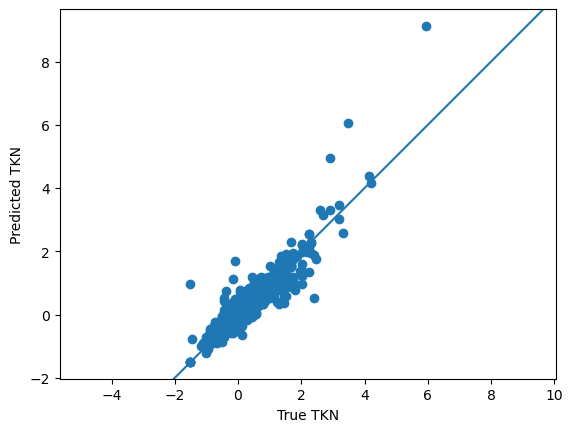

In [34]:
test_predictions = rf_model.predict(X_test)

plt.scatter(Y_test, test_predictions)
plt.xlabel('True TKN')
plt.ylabel('Predicted TKN')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100])

In [35]:
mse = mean_squared_error(Y_test, test_predictions)
print('The mse is:', mse)

The mse is: 0.11579398718785443


In [36]:
# Print out the prediction scores
print('MSE: {}'.format(mean_squared_error(Y_test, test_predictions)))
print('RMSE: {}'.format(np.sqrt(mean_squared_error(Y_test, test_predictions))))
print('MAE: {}'.format(mean_absolute_error(Y_test, test_predictions)))
print('R-SQ: {}'.format(r2_score(Y_test, test_predictions)))

MSE: 0.11579398718785443
RMSE: 0.3402851556971806
MAE: 0.22342004052798445
R-SQ: 0.8379591913222264


Understand Feature Importance

In [43]:
def plot_feature_importance(importance, names):
    '''
    this code is from here: 
    https://www.analyseup.com/learn-python-for-data-science/python-random-forest-feature-importance-plot.html
    '''
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title('FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.show()

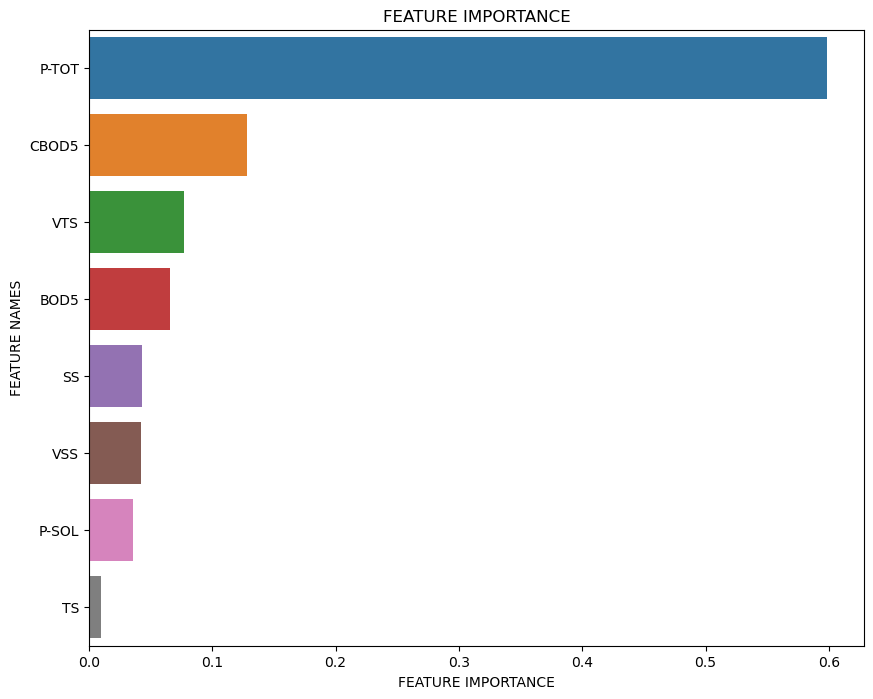

In [45]:
col = ['SS','VSS','VTS','TS','BOD5','CBOD5','P-TOT','P-SOL']
data = pd.DataFrame(X_train, columns=col)
plot_feature_importance(rf_model.feature_importances_, data.columns)

SHAP Evaluation

In [46]:
import shap

In [49]:
# Run the explainer to calculate the SHAP values
explainer = shap.Explainer(rf_model.predict, X_test)
rf_shap_values = explainer(X_test)

Exact explainer: 878it [33:03,  2.27s/it]                                                                              


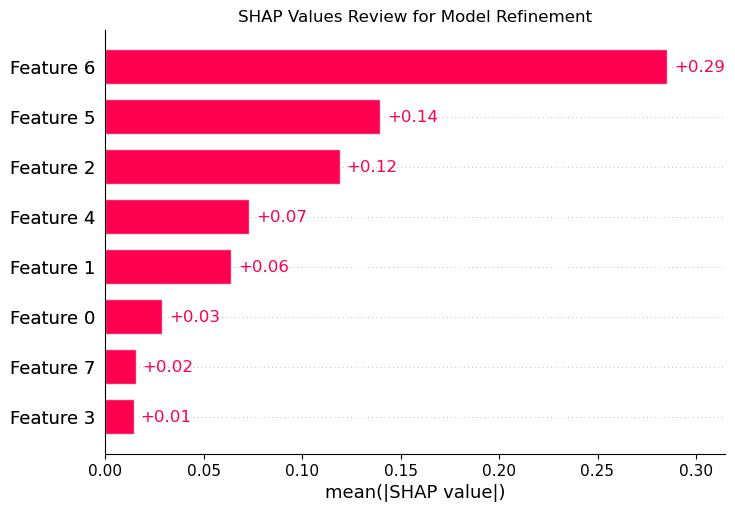

In [62]:
plt.title("SHAP Values Review for Model Refinement")
shap.plots.bar(rf_shap_values)

# XGB Gradient Boosting

Set Hyperparameters and Model Architecture​

In [37]:
# XGB parameters (extreme gradient boosting)
params_xgb = {'objective': 'reg:squarederror',
              'n_estimators': 2000,  # number of trees 
              'learning_rate': 0.01, 
              'max_depth': 5,       # levels in each tree
              'reg_alpha': 1,
              'reg_lambda': 0,}

Evaluate the Model

In [38]:
xgb_model = XGBRegressor(**params_xgb)

In [39]:
%%time
xgb_model.fit(X_train, Y_train)

CPU times: total: 32.2 s
Wall time: 4.21 s


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=2000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=1, reg_lambda=0, ...)

Make Predictions

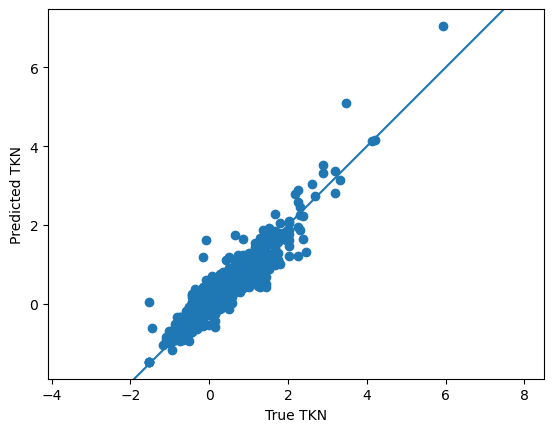

In [40]:
test_predict_XG = xgb_model.predict(X_test)

plt.scatter(Y_test, test_predict_XG)
plt.xlabel('True TKN')
plt.ylabel('Predicted TKN')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100])

In [41]:
mse = mean_squared_error(Y_test, test_predict_XG)
mse

0.08621848121181844

In [42]:
# print out the prediction scores
print('MSE: {}'.format(mean_squared_error(Y_test, test_predict_XG)))
print('RMSE: {}'.format(np.sqrt(mean_squared_error(Y_test, test_predict_XG))))
print('MAE: {}'.format(mean_absolute_error(Y_test, test_predict_XG)))
print('R-SQ: {}'.format(r2_score(Y_test, test_predict_XG)))

MSE: 0.08621848121181844
RMSE: 0.2936298370598915
MAE: 0.2142687364000952
R-SQ: 0.879346823113818
